# 3DMedical-Imaging-Preprocessing-All-you-need

From the last year of my undergrade studies I was very queries about Biomedical Imaging. But until the starting my master I don't have the chance to go deep into the medical imaging. Like most people at the begining I also suffered and was bit confussed about few thing. In this node book I will try to easy explain commonly used Preprocessing in Medical Imaging.

In this tutorial we will be using Public Abdomen Dataset From: Multi-Atlas Labeling Beyond the Cranial Vault - Workshop and Challenge Link: https://www.synapse.org/#!Synapse:syn3193805/wiki/217789

Reference: https://github.com/DLTK/DLTK

Lets Start with Import libararies 

## Import libararies 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import math
from skimage.filters import threshold_mean
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import cv2
import math

## Reading Nifti Image 

We are going to use *SimpleITK* python Libarary for most of our preprocessing task in this Notebook.Hopefully you will be find it very easy to use

CT Shape=(147, 512, 512)
CT Mask Shape=(147, 512, 512)


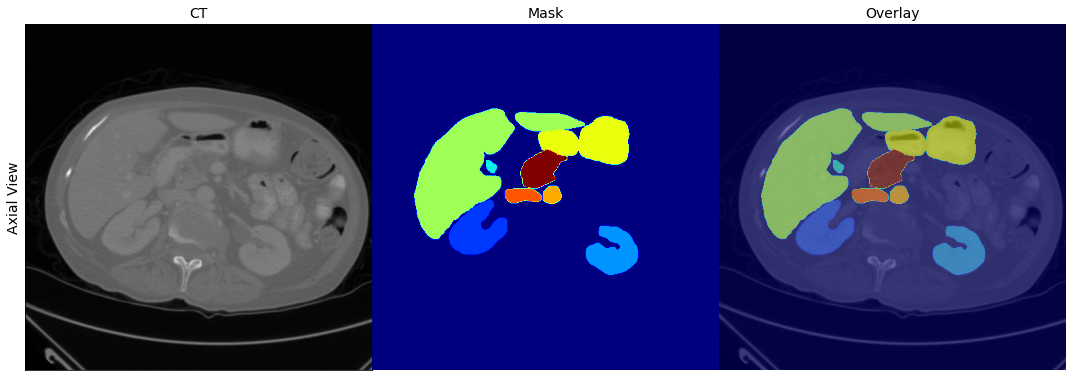

In [2]:
# Reading- Image
#-|path of the data
ct_path='D:/Science/Github/3D-Medical-Imaging-Preprocessing-All-you-need/Data/img0001.nii.gz'
ct_label_path='D:/Science/Github/3D-Medical-Imaging-Preprocessing-All-you-need/Data/label0001.nii.gz'

# CT
img_sitk  = sitk.ReadImage(ct_path, sitk.sitkFloat32) # Reading CT
image     = sitk.GetArrayFromImage(img_sitk) #Converting sitk_metadata to image Array
# Mask
mask_sitk = sitk.ReadImage(ct_label_path,sitk.sitkInt32) # Reading CT
mask      = sitk.GetArrayFromImage(mask_sitk)#Converting sitk_metadata to image Array

print('CT Shape={}'.format(image.shape))
print('CT Mask Shape={}'.format(mask.shape))

#----Lets plot 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask[100, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(image[100, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask[100, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Intensity Normalization 

Now we know how to load the nifti data. Next thing is to learn how to normalize the intensities

In [3]:
def normalise(image):
    # normalise and clip images -1000 to 800
    np_img = image
    np_img = np.clip(np_img, -1000., 800.).astype(np.float32)
    return np_img


def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret


def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret


def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""

    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret



Normalize_minun100_to_800hu=normalise(image)
Normalize_0mean_UnitVr=whitening(image)
Normalize_0to1=normalise_zero_one(image)
normalise_minus1_to1=normalise_one_one(image)


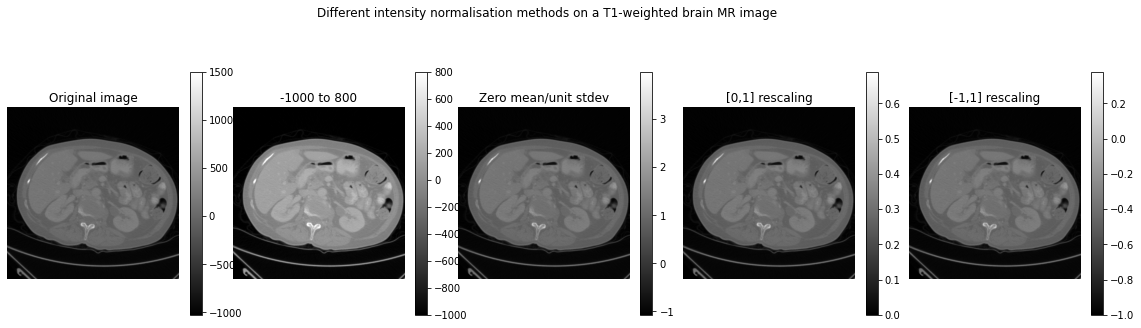

In [4]:
f, axarr = plt.subplots(1, 5, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a Abdomen CT')

img = axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(Normalize_minun100_to_800hu[100, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('-1000 to 800')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(Normalize_0mean_UnitVr[100, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(Normalize_0to1[100, :, :]), cmap='gray',origin='lower');
axarr[3].axis('off')
axarr[3].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[3])

img = axarr[4].imshow(np.squeeze(normalise_minus1_to1[100, :, :]), cmap='gray',origin='lower');
axarr[4].axis('off')
axarr[4].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[4])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

# Resampling 

CT Shape Original=(147, 512, 512), Resampled to 1mm=(441, 342, 342)
CT Mask Shape=(147, 512, 512), Resampled to 1mm=(441, 342, 342)


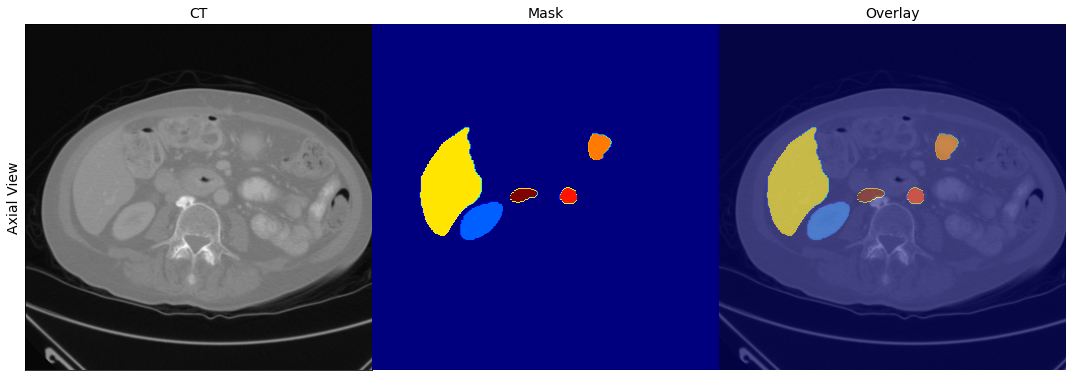

In [5]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    # resample images to 2mm spacing with simple itk

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


ct_resampled_to1m=resample_img(img_sitk, out_spacing=[1, 1, 1], is_label=False)
ct_resampled_to1m=sitk.GetArrayFromImage(ct_resampled_to1m)
mask_resampled_to1m=resample_img(mask_sitk, out_spacing=[1, 1, 1], is_label=True)
mask_resampled_to1m=sitk.GetArrayFromImage(mask_resampled_to1m)
print('CT Shape Original={}, Resampled to 1mm={}'.format(image.shape,ct_resampled_to1m.shape))
print('CT Mask Shape={}, Resampled to 1mm={}'.format(mask.shape,mask_resampled_to1m.shape))

#----Lets plot 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(ct_resampled_to1m[250, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask_resampled_to1m[250, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(ct_resampled_to1m[250, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask_resampled_to1m[250, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Crop or Padding 

C:\Users\tusha\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


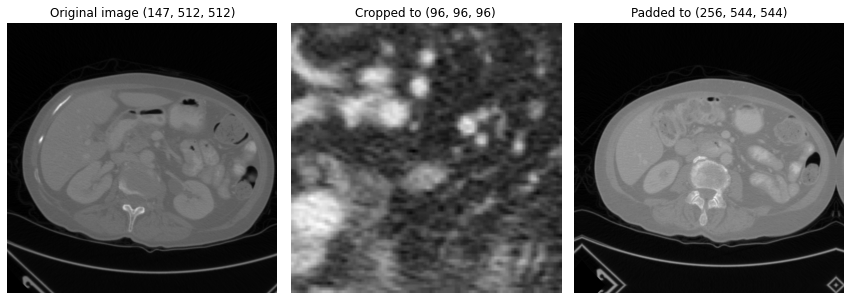

In [17]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)


# Crop to [64, 64, 64]
img_cropped = resize_image_with_crop_or_pad(image, [96, 96, 96], mode='symmetric')

# Resizing image to [128, 256, 256] required padding
img_padded = resize_image_with_crop_or_pad(image, [256, 544, 544], mode='symmetric')

# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,15));
axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(image.shape))

axarr[1].imshow(np.squeeze(img_cropped[32, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(img_cropped.shape))

axarr[2].imshow(np.squeeze(img_padded[140, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(img_padded.shape))
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();